# Homework 3
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

In [4]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

### Task 1

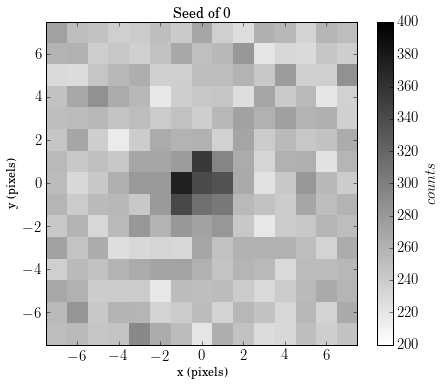

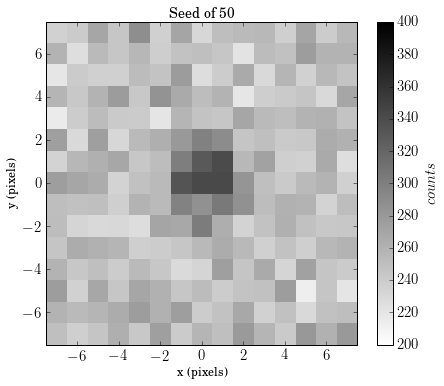

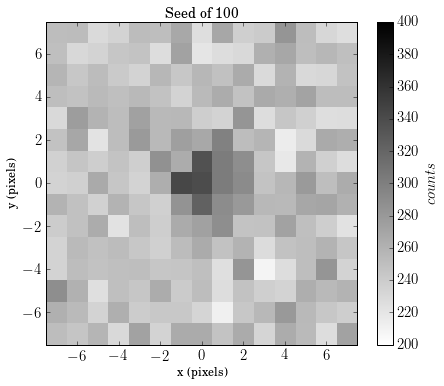

In [5]:
### Make your three simulated images here
# Simulated with seed of 0
image1 = simulatedImage(0)
plotCutout(image1, title = 'Seed of 0')

# Simulated with seed of 50
image2 = simulatedImage(50)
plotCutout(image2, title = 'Seed of 50')

# Simulated with seed of 100
image3 = simulatedImage(100)
plotCutout(image3, title = 'Seed of 100')

In [6]:
# Run apPhot to print the estimated flux
apPhot1 = apPhot(image1)
apPhot2 = apPhot(image2)
apPhot3 = apPhot(image3)

print "Estimated Flux of image 1:", apPhot1
print "Estimated Flux of image 2:", apPhot2
print "Estimated Flux of image 3:", apPhot3

Estimated Flux of image 1: 951.0
Estimated Flux of image 2: 932.0
Estimated Flux of image 3: 837.0


In [7]:
#Run psfPhot to print the true flux with minimized chi^2
psfPhot1 = psfPhot(image1)
psfPhot2 = psfPhot(image2)
psfPhot3 = psfPhot(image3)

print "True Flux of image 1:", psfPhot1
print "True Flux of image 2:", psfPhot2
print "True Flux of image 3:", psfPhot3

True Flux of image 1: 1044
True Flux of image 2: 985
True Flux of image 3: 897


### Task 2

In [8]:
def centerPhot(image):
    
    mid_x = len(image)/2
    mid_y = len(image[0])/2
    mid_pix = image[mid_y][mid_x]
    return mid_pix

In [9]:
print "Center pixel magnitude of image 1:", centerPhot(image1) 
print "Actual magnitude of image 1:", psfPhot1
print "Center pixel magnitude of image 2:", centerPhot(image2)
print "Actual magnitude of image 2:", psfPhot2
print "Center pixel magnitude of image 3:", centerPhot(image3)
print "Actual magnitude of image 3:", psfPhot3

Center pixel magnitude of image 1: 341
Actual magnitude of image 1: 1044
Center pixel magnitude of image 2: 342
Actual magnitude of image 2: 985
Center pixel magnitude of image 3: 340
Actual magnitude of image 3: 897


Comment on the result!

In [10]:
print "The center pixel estimater is biased because the true value" 
print "for magnitude of the simulated image is roughly three times"
print "larger than that of the center pixel."

The center pixel estimater is biased because the true value
for magnitude of the simulated image is roughly three times
larger than that of the center pixel.


### Task 3 

In [11]:
"""
Generate a thousand different simulated images using 
simulatedImage, and compute centerPhot, psfPhot, and 
apPhot for each simulated image. Plot the histogram 
of estimates for each (three histogram in total), as 
well as the mean (using np.average) and standard 
deviation (with np.std).
"""

def image_generator(sim_num, seed):
    
    apPhotArr = []
    psfPhotArr = []
    centPhotArr = []
    for num in range(sim_num):
        image = simulatedImage(seed)
        apPhots = apPhot(image)
        apPhotArr.append(apPhots)
        psfPhots = psfPhot(image)
        psfPhotArr.append(psfPhots)
        centPhot = centerPhot(image)
        centPhotArr.append(centPhot)
    total_dat = [apPhotArr, psfPhotArr, centPhotArr]
    return total_dat

In [12]:
# Implement the 1000 images

Seed_dat = image_generator(1000, None)

In [13]:
# Calculate the average of psfPhot, apPhot, and centerPhot

apAvg = np.average(Seed_dat[0])
psfAvg = np.average(Seed_dat[1])
centAvg = np.average(Seed_dat[2])

apStd = np.std(Seed_dat[0])
psfStd = np.std(Seed_dat[1])
centStd = np.std(Seed_dat[2])

In [14]:
print "apAvg:", apAvg, 
print ", apStd:", apStd
print "psfAvg:", psfAvg,
print ", psfStd:", psfStd
print "centAvg:", centAvg,
print ", centStd:", centStd

apAvg: 946.942 , apStd: 94.2940752964
psfAvg: 997.235 , psfStd: 79.1467230844
centAvg: 356.249 , centStd: 19.2176220954


In [15]:
# Freedman-Diaconis rule
def FD(dist, size):
    """
    Input:
        dist: Distribution sample
        size: Number of entries in the sample
    
    Output:
        bin_size: Freedman-diaconis rule bin width
    """
    
    q25 = np.percentile(dist, 25)
    q75 = np.percentile(dist, 75)
    IQR = q75 - q25
    bin_size = (2*IQR)/(np.cbrt(size))
    return bin_size

ap_bin_width = FD(Seed_dat[0], 1000)
psf_bin_width = FD(Seed_dat[1], 1000)
cent_bin_width = FD(Seed_dat[2], 1000)

ap_bin = round((max(Seed_dat[0])-min(Seed_dat[0]))/ap_bin_width)
psf_bin = round((max(Seed_dat[1])-min(Seed_dat[1]))/psf_bin_width)
cent_bin = round((max(Seed_dat[2])-min(Seed_dat[2]))/cent_bin_width)

In [16]:
# Create the gauss curve 

ap_grid = np.linspace(min(Seed_dat[0]), max(Seed_dat[0]),
                    (max(Seed_dat[0])-min(Seed_dat[0]))*500)
psf_grid = np.linspace(min(Seed_dat[1]), max(Seed_dat[1]),
                    (max(Seed_dat[1])-min(Seed_dat[1]))*500) 
cent_grid = np.linspace(min(Seed_dat[2]), max(Seed_dat[2]),
                    (max(Seed_dat[2])-min(Seed_dat[2]))*500) 

ap_gauss = norm(apAvg, apStd).pdf(ap_grid)
psf_gauss = norm(psfAvg, psfStd).pdf(psf_grid)
cent_gauss = norm(centAvg, centStd).pdf(cent_grid)

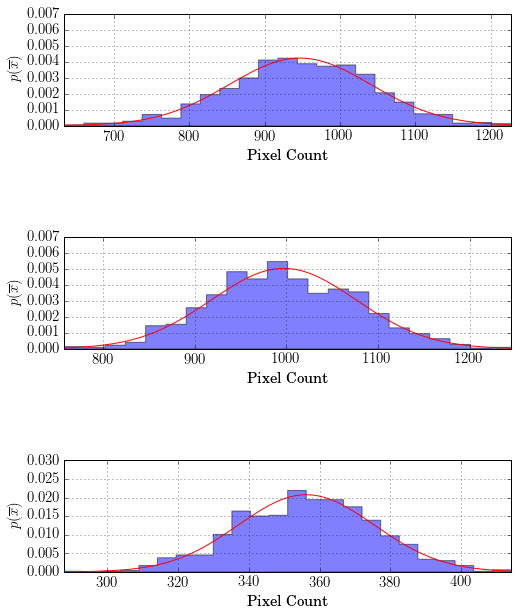

In [17]:
# Plot the histograms

fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=1.0)

# Plot of the ap histogram
ax = fig.add_subplot(311)
ax.hist(Seed_dat[0], bins=ap_bin, facecolor='blue', alpha=0.5, 
        histtype='stepfilled', normed=True, label='Pixel Counts')
ax.plot(ap_grid, ap_gauss, ls='-', c='red', label='Gaussian Fit')
ax.set_xlim(min(Seed_dat[0]), max(Seed_dat[0]))
ax.set_ylim(0,0.007)
ax.set_xlabel('Pixel Count')
ax.set_ylabel(r'$p(\overline{x})$')
plt.grid(True)

# Plot the psf histogram

ax1 = fig.add_subplot(312)
ax1.hist(Seed_dat[1], bins=round(psf_bin), facecolor='blue', alpha=0.5, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax1.plot(psf_grid, psf_gauss, ls='-', c='red', label='Gaussian Fit')
ax1.set_xlim(min(Seed_dat[1]), max(Seed_dat[1]))
ax1.set_ylim(0,0.007)
ax1.set_xlabel('Pixel Count')
ax1.set_ylabel(r'$p(\overline{x})$')
plt.grid(True)

# Plot the center pixel histogram

ax2 = fig.add_subplot(313)
ax2.hist(Seed_dat[2], bins=round(cent_bin), facecolor='blue', alpha=0.5, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax2.plot(cent_grid, cent_gauss, ls='-', c='red', label='Gaussian Fit')
ax2.set_xlim(min(Seed_dat[2]), max(Seed_dat[2]))
ax2.set_ylim(0,0.03)
ax2.set_xlabel('Pixel Count')
ax2.set_ylabel(r'$p(\overline{x})$')
plt.grid(True)

Task 4

In [21]:
"""
Some of the estimators above will be (very) biased, and standard 
deviations (which are the measure of the accuracy of the estimate) 
are not directly comparable. To make them comparable, multiply each 
of them by Atrue/Amean (where Amean is the mean computed above). 
This mimics what would happen if we were to remove the bias by 
calibrating with standard stars. What do you observe about the 
recalibrated widths of the histograms? Which one is the narrowest, 
and why?
"""

# Calculate Ratios of Atrue/Amean

apRatio = Atrue/apAvg
psfRatio = Atrue/psfAvg
centRatio = Atrue/centAvg

# Find comparable standard deviations and comparable samples

apStdC = apRatio * apStd
psfStdC = psfRatio * psfStd
centStdC = centRatio * centStd

apDatC = apRatio * np.array(Seed_dat[0])
psfDatC = psfRatio * np.array(Seed_dat[1])
centDatC = centRatio * np.array(Seed_dat[2])

apAvgC = np.average(apDatC)
psfAvgC = np.average(psfDatC)
centAvgC = np.average(centDatC)

# Calculate the new grid and guass fits

ap_gridC = np.linspace(min(apDatC), max(apDatC),(max(apDatC)-min(apDatC))*500)
psf_gridC = np.linspace(min(psfDatC), max(psfDatC),(max(psfDatC)-min(psfDatC))*500) 
cent_gridC = np.linspace(min(centDatC), max(centDatC),(max(centDatC)-min(centDatC))*500)

ap_gaussC = norm(apAvgC, apStdC).pdf(ap_gridC)
psf_gaussC = norm(psfAvgC, psfStdC).pdf(psf_gridC)
cent_gaussC = norm(centAvgC, centStdC).pdf(cent_gridC)

# Find the bin width

ap_bin_widthC = FD(apDatC, 1000)
psf_bin_widthC = FD(psfDatC, 1000)
cent_bin_widthC = FD(centDatC, 1000)

ap_binC = round((max(apDatC)-min(apDatC))/ap_bin_widthC)
psf_binC = round((max(psfDatC)-min(psfDatC))/psf_bin_widthC)
cent_binC = round((max(centDatC)-min(centDatC))/cent_bin_widthC)

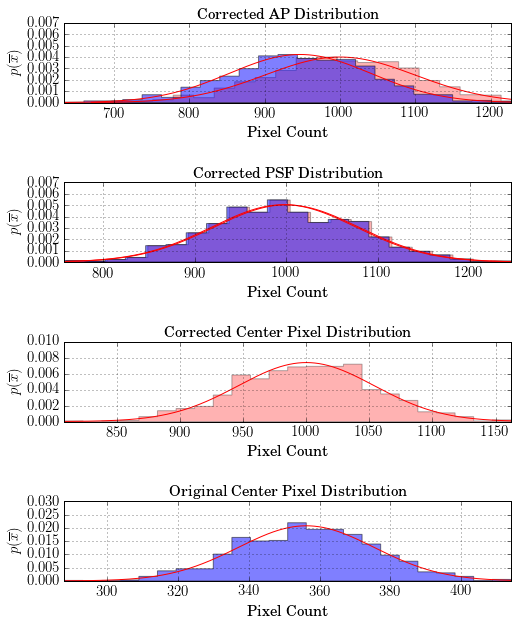

In [38]:
# Plot new histograms

fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=1.0)

# Plot of the ap histogram
ax = fig.add_subplot(411)
ax.hist(apDatC, bins=ap_binC, facecolor='red', alpha=0.3, 
        histtype='stepfilled', normed=True, label='Pixel Counts')
ax.plot(ap_gridC, ap_gaussC, ls='-', c='red', label='Gaussian Fit')
ax.set_xlim(min(apDatC), max(apDatC))
ax.set_ylim(0,0.007)
ax.set_xlabel('Pixel Count')
ax.set_ylabel(r'$p(\overline{x})$')
ax.set_title('Corrected AP Distribution')
plt.grid(True)

# Plot the psf histogram

ax1 = fig.add_subplot(412)
ax1.hist(psfDatC, bins=psf_binC, facecolor='red', alpha=0.3, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax1.plot(psf_gridC, psf_gaussC, ls='-', c='red', label='Gaussian Fit')
ax1.set_xlim(min(psfDatC), max(psfDatC))
ax1.set_ylim(0,0.007)
ax1.set_xlabel('Pixel Count')
ax1.set_ylabel(r'$p(\overline{x})$')
ax1.set_title('Corrected PSF Distribution')
plt.grid(True)

# Plot the center pixel histogram

ax2 = fig.add_subplot(413)
ax2.hist(centDatC, bins=cent_binC, facecolor='red', alpha=0.3, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax2.plot(cent_gridC, cent_gaussC, ls='-', c='red', label='Gaussian Fit')
ax2.set_xlim(min(centDatC), max(centDatC))
ax2.set_ylim(0,0.01)
ax2.set_xlabel('Pixel Count')
ax2.set_ylabel(r'$p(\overline{x})$')
ax2.set_title('Corrected Center Pixel Distribution')
plt.grid(True)

# Plot of the ap histogram
ax = fig.add_subplot(411)
ax.hist(Seed_dat[0], bins=ap_bin, facecolor='blue', alpha=0.5, 
        histtype='stepfilled', normed=True, label='Pixel Counts')
ax.plot(ap_grid, ap_gauss, ls='-', c='red', label='Gaussian Fit')
ax.set_xlim(min(Seed_dat[0]), max(Seed_dat[0]))
ax.set_ylim(0,0.007)
ax.set_xlabel('Pixel Count')
ax.set_ylabel(r'$p(\overline{x})$')
plt.grid(True)

# Plot the psf histogram

ax1 = fig.add_subplot(412)
ax1.hist(Seed_dat[1], bins=round(psf_bin), facecolor='blue', alpha=0.5, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax1.plot(psf_grid, psf_gauss, ls='-', c='red', label='Gaussian Fit')
ax1.set_xlim(min(Seed_dat[1]), max(Seed_dat[1]))
ax1.set_ylim(0,0.007)
ax1.set_xlabel('Pixel Count')
ax1.set_ylabel(r'$p(\overline{x})$')
plt.grid(True)

# Plot the center pixel histogram

ax2 = fig.add_subplot(414)
ax2.hist(Seed_dat[2], bins=round(cent_bin), facecolor='blue', alpha=0.5, 
         histtype='stepfilled', normed=True, label='Pixel Counts')
ax2.plot(cent_grid, cent_gauss, ls='-', c='red', label='Gaussian Fit')
ax2.set_xlim(min(Seed_dat[2]), max(Seed_dat[2]))
ax2.set_ylim(0,0.03)
ax2.set_xlabel('Pixel Count')
ax2.set_ylabel(r'$p(\overline{x})$')
ax2.set_title('Original Center Pixel Distribution')
plt.grid(True)

In [43]:
# What do you observe about the width of the recalibrated histograms?

print "The largest noticable difference between the recalibrated histograms"
print "and the original is where the distributions are centered.   The center"
print "pixel distribution moved from a center of around 355 to around 1000."
print "In fact, all distributions moved to roughly the true estimation of 1000."
print "However, the widths of the distributions for the PSF and AP didn't"
print "change much, because their estimates were relatively close in the first place."
print "When looking at the center pixel distribution, the width is narrower"
print "compared to the other two distributions."
print ""

# Which is narrowest and why?
print "The narrowest distribution is the recalibrated Center Pixel Distribution"
print "because the sample has the smallest spread.  This can be seen in the standard"
print "relative deviations of the distributions."
print ""

print "Calibrated AP distributions Standard Deviation:", apStdC
print "Calibrated PSF distributions Standard Deviation:", psfStdC
print "Calibrated Center Pixel distributions Standard Deviation:", centStdC

The largest noticable difference between the recalibrated histograms
and the original is where the distributions are centered.   The center
pixel distribution moved from a center of around 355 to around 1000.
In fact, all distributions moved to roughly the true estimation of 1000.
However, the widths of the distributions for the PSF and AP didn't
change much, because their estimates were relatively close in the first place.
When looking at the center pixel distribution, the width is narrower
compared to the other two distributions.

The narrowest distribution is the recalibrated Center Pixel Distribution
because the sample has the smallest spread.  This can be seen in the standard
relative deviations of the distributions.

Calibrated AP distributions Standard Deviation: 99.5774559544
Calibrated PSF distributions Standard Deviation: 79.366170546
Calibrated Center Pixel distributions Standard Deviation: 53.9443537957
